Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
# import seaborn as sns
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics
import csv

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [2]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # AZ PHX Sky Harbor Data #
AZW_15 = pd.read_csv("./Data/AZW_15.csv")

# # ENVIMET DATA #
BPS = []
Fname = []
for path in pathlib.Path("./Data/BPS").iterdir():
    if path.is_file():
        current_file = pd.read_csv(path)
        BPS.append(current_file)
        Fname.append(path.name.replace('.csv', ''))

# # CAMPUS METABOLISM DATA #
metabol14 = []
for path in pathlib.Path('./Data/metabol14').iterdir():
    if path.is_file():
        current_file = pd.read_csv(path)
        metabol14.append(current_file)

# ## Drop last row of EnviMet Data
for i in range(len(BPS)):
    BPS[i] = BPS[i].drop(16)

# ## Save files as pickle
AZW_15.to_pickle("./Data/AZW_15.pkl")

with open('./Data/BPS.pkl', 'wb') as f:
    pickle.dump(BPS, f)

with open('./Data/Fname.pkl', 'wb') as f:
    pickle.dump(Fname, f)

with open('./Data/metabol14.pkl', 'wb') as f:
    pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [3]:
# We will convert these to df depending on the building we choose
# 2. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 3. Load names of BPS files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 4. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)

## 2.3 Choose building name to import

In [4]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Goldwater
Best Hall
COD North
Bio Design Institute B
University Club
Engineering Research Ctr
ISTB 2
Interdisciplinary AB
Health Services
ISTB 5
ISTB 1
Lifescience A_B_D
Bio Design Institute A
ISTB 4
Enter building name: ISTB 1


## 2.4 Create Data Frame

In [17]:
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env


Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

ISTB 1


In [18]:
#read csv and convert to pkl, then read pkl below
# AZW_15 = pd.read_csv("./Data/AZW_15.csv")

# DF for AZ Weather Data (15-min)
weather_station = pd.read_pickle('./Data/AZW_15.pkl')



# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [19]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

envimet = envimet.set_index('Date_Time')
print(envimet)

['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']
                 Month  Time   Air Temp  Rel Humid
Date_Time                                         
06/09/2018 05:00    06  0500  30.119833  12.204521
06/09/2018 06:00    06  0600  28.439681  18.227189
06/09/2018 07:00    06  0700  29.212967  19.053349
06/09/2018 08:00    06  0800  31.196816  18.135058
06/09/2018 09:00    06  0900  33.564851  15.471231
06/09/2018 10:00    06  1000  35.369671  11.311710
06/09/2018 11:00    06  1100  36.443335   9.063576
06/09/2018 12:00    06  1200  37.508947   7.840227
06/09/2018 13:00    06  1300  38.480960   7.009446
06/09/2018 14:00    06  1400  39.180197   6.389399
06/09/2018 15:00    06  1500  39.584199   6.057600
06/09/2018 16:00    06  1600  39.794207   5.906971
06/09/2018 17:00    06  1700  39.732764   5.871568
06/09/2018 18:00    06  1800  39.456794   5.906116
06/09/2018 19:00    06  1900  38.867983   6.210788
06/09/2018 20:00    06  2000  38.055714   6.646973


/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [20]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

### b) Weather Station dates

In [21]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
weather_station = weather_station.set_index('Date_Time') 

### c) Building energy dates

In [22]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')
print(metabol)

                      KW  CHWTON
tstamp                          
01/01/2018 00:00  185.10   21.02
01/01/2018 00:15  188.49   17.12
01/01/2018 00:30  185.19   16.60
01/01/2018 00:45  184.06   14.99
01/01/2018 01:00  187.10   15.77
...                  ...     ...
12/31/2018 22:45  172.90    8.11
12/31/2018 23:00  172.37    7.37
12/31/2018 23:15  169.94    7.55
12/31/2018 23:30  172.74    8.11
12/31/2018 23:45  173.24    6.93

[35031 rows x 2 columns]


## 3.2 Append Energy Consumption to Weather Station data

In [23]:
weather_station =  pd.concat([metabol, weather_station], axis = 1, join = "inner")

# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# weather_station.to_csv('./Data/weather_st_numstr') # save data with string and numeric date format

## 3.3 Append Energy Consumption to Microclimate Data

In [24]:

time = []
time.append('0500')
time.append('0600')
time.append('0700')
time.append('0800')
time.append('0900')
time.append('1000')
time.append('1100')
time.append('1200')
time.append('1300')
time.append('1400')
time.append('1500')
time.append('1600')
time.append('1700')
time.append('1800')
time.append('1900')
time.append('2000')

month = []
for i in range(16):
    month.append('06')

date = []
date.append('06/09/2018 05:00')
date.append('06/09/2018 06:00')
date.append('06/09/2018 07:00')
date.append('06/09/2018 08:00')
date.append('06/09/2018 09:00')
date.append('06/09/2018 10:00')
date.append('06/09/2018 11:00')
date.append('06/09/2018 12:00')
date.append('06/09/2018 13:00')
date.append('06/09/2018 14:00')
date.append('06/09/2018 15:00')
date.append('06/09/2018 16:00')
date.append('06/09/2018 17:00')
date.append('06/09/2018 18:00')
date.append('06/09/2018 19:00')
date.append('06/09/2018 20:00')
Int_AB_CHWTON = []
x = 15170
for i in range(16):
    Int_AB_CHWTON.append(metabol['CHWTON'][i + x])
    x = x + 3
Int_AB_KW = []
x = 15170
for i in range(16):
    Int_AB_KW.append(metabol['KW'][i + x])
    x = x + 3
Int_AB_June_9 = pd.DataFrame()
Int_AB_June_9['month'] = month
Int_AB_June_9['time'] = time
Int_AB_June_9['CHWTON'] = Int_AB_CHWTON
Int_AB_June_9['KW'] = Int_AB_KW
Int_AB_June_9['date'] = date
Int_AB_June_9['Date_Time'] = Int_AB_June_9['date'] + ' ' + Int_AB_June_9['time']
Int_AB_June_9 = Int_AB_June_9.set_index(['Date_Time'])
# print(Int_AB_June_9)
# Int_AB_June_9['CHWTON']
# envimet = envimet[['Air Temp']]
# Int_AB_June_9[['Air Temp']] = envimet
# microclimate = pd.concat()
Int_AB_June_9 = Int_AB_June_9[['CHWTON']]
Int_AB_June_9 = Int_AB_June_9.set_index(envimet.index)
envimet['CHWTON']= Int_AB_June_9

In [63]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
def prepare_data(dataset):
    Y = dataset['CHWTON']
    X = dataset[['Air Temp', 'Rel Humid']]
    Y= Y.values.reshape(-1, 1)
    # create scaler
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    print(X_scaled.shape)
    # #do for output variables
    scaler2 = StandardScaler()
    Y_scaled = scaler2.fit_transform(Y)
    X_scaled = np.asarray(X_scaled).astype('float32')
    Y_scaled = np.asarray(Y_scaled).astype('float32')
    return X_scaled,Y_scaled
def define_model():
    model = Sequential()
    model.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics = ['mse','mae'])
    return model
def plot_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def evaluate(model,X,Y):
    #evaluate on test dataset
    Y_preds = model.predict(X)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    test_loss = model.evaluate(X, Y)
    return RMSE, test_loss

X,Y = prepare_data(weather_station)
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
base_model = define_model()
history = base_model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)


(34620, 2)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
174/174 [==============================] - 0s 989us/step - loss: 0.4452 - mse: 0.4452 - mae: 0.5170 - val_loss: 0.1009 - val_mse: 0.1009 - val_mae: 0.2414
Epoch 2/50
174/174 [==============================] - 0s 644us/step - loss: 0

Epoch 45/50
174/174 [==============================] - 0s 648us/step - loss: 0.0865 - mse: 0.0865 - mae: 0.2236 - val_loss: 0.0848 - val_mse: 0.0848 - val_mae: 0.2169
Epoch 46/50
174/174 [==============================] - 0s 639us/step - loss: 0.0864 - mse: 0.0864 - mae: 0.2231 - val_loss: 0.0839 - val_mse: 0.0839 - val_mae: 0.2183
Epoch 47/50
174/174 [==============================] - 0s 638us/step - loss: 0.0862 - mse: 0.0862 - mae: 0.2230 - val_loss: 0.0842 - val_mse: 0.0842 - val_mae: 0.2209
Epoch 48/50
174/174 [==============================] - 0s 661us/step - loss: 0.0865 - mse: 0.0865 - mae: 0.2231 - val_loss: 0.0842 - val_mse: 0.0842 - val_mae: 0.2230
Epoch 49/50
174/174 [==============================] - 0s 658us/step - loss: 0.0861 - mse: 0.0861 - mae: 0.2229 - val_loss: 0.0839 - val_mse: 0.0839 - val_mae: 0.2209
Epoch 50/50
174/174 [==============================] - 0s 655us/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2228 - val_loss: 0.0842 - val_mse: 0.0842 - val_mae: 0.222

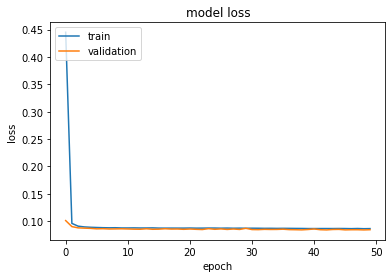

1/1 [==============================] - 0s 921us/step - loss: 0.4653 - mse: 0.4653 - mae: 0.5746
0.28834048
0.6820992


In [64]:
plot_curve(history)
RMSE, _ = evaluate(base_model, X_test, Y_test)
RMSE_base, _ = evaluate(base_model, X_limited,Y_limited)
print(RMSE)
print(RMSE_base)

In [67]:
def fine_tune(model):
    model.trainable = True
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 1
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
      layer.trainable =  False
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics = ['mse','mae'])
    return model
fine_tuned_model = fine_tune(base_model)
X_limited,Y_limited = prepare_data(envimet)
history = fine_tuned_model.fit(X_limited,Y_limited, epochs=50, verbose=1)

Number of layers in the base model:  4
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 241
Trainable params: 205
Non-trainable params: 36
_________________________________________________________________
(16, 2)
Epoch 1/50
1/1 [==============================] - 0s 757us/step - loss: 0.3919 - mse: 0.3919 - mae: 0.5261
Epoch 2/50
1/1 [==============================] - 0s 806us/step - loss: 0.3882 - mse: 0.3882 - mae:

In [68]:
RMSE_fine_tune ,_= evaluate(fine_tuned_model,X_limited,Y_limited)
print(RMSE_fine_tune)

1/1 [==============================] - 0s 726us/step - loss: 0.2657 - mse: 0.2657 - mae: 0.4237
0.51549023
